# Load data

In [3]:
import math
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest, wilcoxon
import statsmodels.stats.multicomp as multi
import statsmodels.api as sm

!pip install lmppl
import lmppl

In [8]:
sanitycheck_data = pd.read_csv("sanitycheck_data.csv")
exp1_data = pd.read_csv("exp1_data.csv")
exp2_data = pd.read_csv('exp2_data.csv')
exp1_data = exp1_data[exp1_data['type'] != 4] # Remove datapoints not used in paper
assert len(exp1_data) == 2123

# Code for calculating perplexities

In [ ]:
# Experiment 1

# Load data
exp1_data = pd.read_csv('exp1_data.csv')

# Load LM. Change to other LM as desired
scorer = lmppl.LM('mistralai/Mistral-7B-v0.1')

# Helper function for calculating perplexity
def calculate_perplexity(inputs):
    return scorer.get_perplexity(inputs)

# For each sentence pair, calculate perplexity for four orders
uuoo = []; oouu = []; uoou = []; ouuo = []
batch_size = 10
for i in range(math.ceil(len(exp1_data)/batch_size)):
  prompts = []
  for j in range(k):
    if ((i*batch_size)+j) < len(exp1_data):
      sentence = exp1_data['underspecified sentence'][(i*k)+j]
      control_sentence = exp1_data['control sentence'][(i*batch_size)+j]
      # Change to ambiguous/little detail/little information as desired
      uuoo_prompt = f"This is an underspecified sentence: '{sentence}'. This is its more specified counterpart: '{control_sentence}'."
      uoou_prompt = f"This is an underspecified sentence: '{control_sentence}'. This is its more specified counterpart: '{sentence}'."
      oouu_prompt = f"This is a more specified sentence: '{control_sentence}'. This is its underspecified counterpart: '{sentence}'."
      ouuo_prompt = f"This is a more specified sentence: '{sentence}'. This is its underspecified counterpart: '{control_sentence}'."
      prompts += [uuoo_prompt, uoou_prompt, oouu_prompt, ouuo_prompt]
  ppls = calculate_perplexity(prompts)
  for j in range(batch_size):
    if ((i*batch_size)+j) < len(exp1_data):
      uuoo.append(ppls[(j*4)]); uoou.append(ppls[(j*4)+1]); oouu.append(ppls[(j*4)+2]); ouuo.append(ppls[(j*4)+3])
# Save in dataframe
exp1_data["Mistral over-under uuoo perplexity"] = uuoo
exp1_data["Mistral over-under uoou perplexity"] = uoou
exp1_data["Mistral over-under oouu perplexity"] = oouu
exp1_data["Mistral over-under ouuo perplexity"] = ouuo

In [ ]:
# Experiment 2

# Load data
exp2_data = pd.read_csv("exp2_data.csv")

# Load LM. Change to other LM as desired
scorer = lmppl.LM('mistralai/Mistral-7B-v0.1')

# Helper function for calculating perplexity
def calculate_perplexity(inputs):
    return scorer.get_perplexity(inputs)

# For each sentence pair, calculate perplexity for four orders
sen_correct = []; sen_incorrect = []; csen_correct = []; csen_incorrect = []
batch_size = 10
for i in range(math.ceil(len(exp2_data)/batch_size)):
  prompts = []
  for j in range(batch_size):
    if ((i*batch_size)+j) < len(exp2_data):
      # Change to different prompt type of alternative reading as desired
      sc = f"{exp2_data['underspecified sentence'][(i*batch_size)+j]}. {exp2_data['continuation of control sentence 2'][(i*batch_size)+j]}"
      si = f"{exp2_data['underspecified sentence'][(i*batch_size)+j]}. {exp2_data['continuation of control sentence 1'][(i*batch_size)+j]}"
      csc = f"{exp2_data['control sentence 2'][(i*batch_size)+j]}. {exp2_data['continuation of control sentence 2'][(i*batch_size)+j]}"
      csi = f"{exp2_data['control sentence 2'][(i*batch_size)+j]}. {exp2_data['continuation of control sentence 1'][(i*batch_size)+j]}"
      prompts += [sc, si, csc, csi]
  ppls = calculate_perplexity(prompts)
  for j in range(batch_size):
    if ((i*batch_size)+j) < len(exp2_data):
      sen_correct.append(ppls[(j*4)]); sen_incorrect.append(ppls[(j*4)+1]); csen_correct.append(ppls[(j*4)+2]); csen_incorrect.append(ppls[(j*4)+3])
# Save in dataframe
exp2_data["Mistral counter base sen_correct"] = sen_correct
exp2_data["Mistral counter base sen_incorrect"] = sen_incorrect
exp2_data["Mistral counter base csen_correct"] = csen_correct
exp2_data["Mistral counter base csen_incorrect"] = csen_incorrect

# Qualitative analysis

In [6]:
# Get proportion correct of experiment 1
df2 = exp1_data.copy()

for model in ["OPT-13b", "Llama2", "GPT2-xl", "Mistral", "Flan-T5 xxl"]:
  for prompt_type in ["under-over", "(un)ambigu", "little/lot detail", "little/lot information"]:
    df2[f"{model} {prompt_type}"] = ((df2[f"{model} {prompt_type} uuoo perplexity"] + df2[f"{model} {prompt_type} oouu perplexity"]) < (df2[f"{model} {prompt_type} uoou perplexity"] + df2[f"{model} {prompt_type} ouuo perplexity"]))
  df2[f"{model}"] = (df2[f"{model} under-over"].astype(int) + df2[f"{model} (un)ambigu"].astype(int) + df2[f"{model} little/lot detail"].astype(int) + df2[f"{model} little/lot information"].astype(int)) / 4
for i in [507, 316, 295, 315, 395, 4, 1104, 678, 516, 1743]:
  print(df2.iloc[i]['underspecified sentence'])
  for model in ["GPT2-xl", "OPT-13b", "Mistral"]:
    print(i, model, df2.iloc[i][model])

Danny approached Andrei; also Yevgeni
507 GPT2-xl 0.25
507 OPT-13b 0.75
507 Mistral 1.0
Andrei and Danny put-down a yellow chair
316 GPT2-xl 0.5
316 OPT-13b 0.75
316 Mistral 1.0
Andrei approached the person with a yellow bag
295 GPT2-xl 0.5
295 OPT-13b 0.75
295 Mistral 1.0
Danny looked at Andrei moving a green chair
315 GPT2-xl 0.5
315 OPT-13b 0.75
315 Mistral 1.0
Andrei and Danny held the yellow bag and chair
395 GPT2-xl 0.75
395 OPT-13b 0.75
395 Mistral 1.0
Although they ran at about the same speed, Sue beat Sally because she had such a bad start.
4 GPT2-xl 0.25
4 OPT-13b 0.25
4 Mistral 0.25
Get yourself a flannel shirt and wear it over a plain tee shirt. 
1104 GPT2-xl 0.75
1104 OPT-13b 0.75
1104 Mistral 0.75
This means you have broken the seal and can now twist off the lid. 
678 GPT2-xl 0.5
678 OPT-13b 1.0
678 Mistral 0.75
4. Do not slurp. 
516 GPT2-xl 0.75
516 OPT-13b 0.75
516 Mistral 1.0
Think about your plant's activity. 
1743 GPT2-xl 0.25
1743 OPT-13b 1.0
1743 Mistral 1.0


# Sentiment data sanity check

In [10]:
# For each model, calculate whether the perplexity of the correct prompts is
# lower than that of the incorrect prompts
matrix = []
for model in ["GPT2", "FlanT5", "OPT", "Mistral", "Llama-13b"]:
  #sanitycheck_data[f"{model} percentage"] = ((sanitycheck_data[f"{model} ppnn perplexity"] + sanitycheck_data[f"{model} nnpp perplexity"]) < (sanitycheck_data[f"{model} nppn perplexity"] + sanitycheck_data[f"{model} pnnp perplexity"]))
  one = sanitycheck_data[f"{model} ppnn perplexity"] < sanitycheck_data[f"{model} pnnp perplexity"]
  two = sanitycheck_data[f"{model} ppnn perplexity"] < sanitycheck_data[f"{model} nppn perplexity"]
  three = sanitycheck_data[f"{model} nnpp perplexity"] < sanitycheck_data[f"{model} nppn perplexity"]
  four = sanitycheck_data[f"{model} nnpp perplexity"] < sanitycheck_data[f"{model} pnnp perplexity"]
  sanitycheck_data[f"{model} percentage"] = (one.astype(int) + two.astype(int) + three.astype(int) + four.astype(int)) / 4
  #sanitycheck_data[f"{model} percentage"] = (one.astype(int) + three.astype(int)) / 2
  matrix.append(sanitycheck_data[f"{model} percentage"].mean())

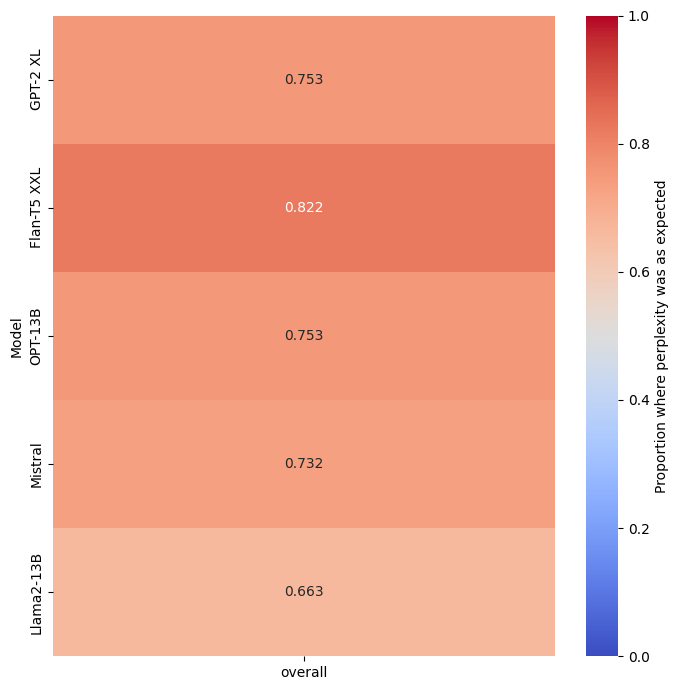

In [11]:
# Plot heatmap
matrix = np.round(matrix, 4)
df_cm = pd.DataFrame(matrix,
                     index = ["GPT-2 XL", "Flan-T5 XXL", "OPT-13B", "Mistral", "Llama2-13B"],
                     columns = ["overall"]
              )
green = seaborn.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize = (7,7))
plt.tight_layout()
heatmap = seaborn.heatmap(df_cm, fmt = '', cmap=green, vmin=0, vmax=1, cbar_kws={'label': 'Proportion where perplexity was as expected'}, annot=True)
heatmap.set(ylabel='Model')
fig = heatmap.get_figure()
fig.tight_layout()
fig.savefig("sentiment_perplexity.pdf", format="pdf")

# Experiment 1 heatmap

In [15]:
# Create matrix for heatmap
matrix = []
for model in ["GPT2-xl", "Flan-T5 xxl", "OPT-13b",  "Llama2", "Mistral"]:
  # For each prompt type, calculate whether the perplexity of the correct prompts is
  # lower than that of the incorrect prompts
  for prompt_type in ["under-over", "(un)ambigu", "little/lot detail", "little/lot information"]:
    one = exp1_data[f"{model} {prompt_type} uuoo perplexity"] < exp1_data[f"{model} {prompt_type} uoou perplexity"]
    two = exp1_data[f"{model} {prompt_type} oouu perplexity"] < exp1_data[f"{model} {prompt_type} ouuo perplexity"]
    three = exp1_data[f"{model} {prompt_type} uuoo perplexity"] < exp1_data[f"{model} {prompt_type} ouuo perplexity"]
    four = exp1_data[f"{model} {prompt_type} oouu perplexity"] < exp1_data[f"{model} {prompt_type} uoou perplexity"]
    exp1_data[f"{model} {prompt_type} proportion"] = (one.astype(int) + two.astype(int) + three.astype(int) + four.astype(int)) / 4
    #exp1_data[f"{model} {prompt_type} proportion"] = ((exp1_data[f"{model} {prompt_type} uuoo perplexity"] + exp1_data[f"{model} {prompt_type} oouu perplexity"]) < (exp1_data[f"{model} {prompt_type} ouuo perplexity"] + exp1_data[f"{model} {prompt_type} uoou perplexity"]))

  #Comment out to display by type or by phenomenon
  #subdivision = 'phenomenon'
  subdivision = 'type'

  classes = exp1_data[subdivision].unique()
  classes.sort()
  row = []
  # Calculate the average over prompt types
  exp1_data[f"{model}"] = (exp1_data[f"{model} under-over proportion"] +
                           exp1_data[f"{model} (un)ambigu proportion"] +
                           exp1_data[f"{model} little/lot detail proportion"] +
                           exp1_data[f"{model} little/lot information proportion"]) / 4
  # Create matrix for heatmap
  p = exp1_data[f"{model}"].mean()
  row.append(p)
  for klasje in classes:
    p = exp1_data[exp1_data[subdivision] == klasje][f"{model}"].mean()
    row.append(p)
  matrix.append(row)

In [16]:
# Function for adding significance test markers
def check_significance(df, matrix):
  newmatrix = []
  for row in matrix:
    newrow = []
    for datapoint, typetje in zip(row, ["Overall"] + list(df['phenomenon'].unique())):#[0,1,2,3,4]):
      if typetje == "Overall":
        if binomtest(round(datapoint * len(df) * 4), len(df) * 4, alternative="greater").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        elif binomtest(round(datapoint * len(df) * 4), len(df) * 4, alternative="less").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        else:
          newrow.append(str(round(datapoint, 4)))
      else:
        if binomtest(round(datapoint * len(df[df['phenomenon'] == typetje]) * 4), len(df[df['phenomenon'] == typetje]) * 4, alternative="greater").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        elif binomtest(round(datapoint * len(df[df['phenomenon'] == typetje]) * 4), len(df[df['phenomenon'] == typetje]) * 4, alternative="less").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        else:
          newrow.append(str(round(datapoint, 4)))
    newmatrix.append(newrow)
  return newmatrix

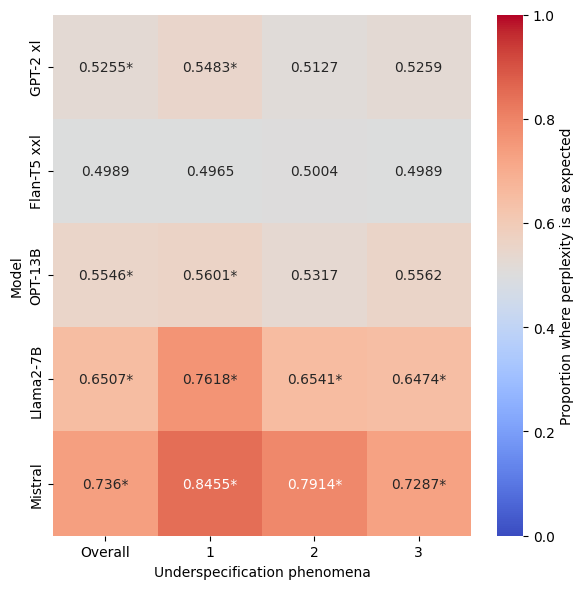

In [20]:
# Plot heatmap
labels = check_significance(exp1_data, matrix)
df_cm = pd.DataFrame(matrix,
                     index = ["GPT-2 xl", "Flan-T5 xxl", "OPT-13B", "Llama2-7B", "Mistral"],
                     #Comment out to display by type or by phenomenon
                     #columns = ["Overall", "Added compound", "Conjunction amb.", "Ellipsis", "Fused head", "Implicit ref.", "Logical Form", "Metonymic ref.", "PP attach. amb.", "Referential amb.", "VP attach. amb."]
                     columns = ["Overall", "1", "2", "3"]
              )
green = seaborn.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize = (6, 6))
plt.tight_layout()
heatmap = seaborn.heatmap(df_cm, fmt = '', cmap=green, vmin=0, vmax=1, cbar_kws={'label': 'Proportion where perplexity is as expected'}, annot=labels)
heatmap.set(xlabel="Underspecification phenomena", ylabel='Model')
fig = heatmap.get_figure()
fig.tight_layout()
fig.savefig("exp1_heatmap.pdf", format="pdf")

# Experiment 2 heatmap

In [22]:
# Create matrix for heatmap
matrix = []
domain = 0
criterium = 'type'
print(len(exp2_data[exp2_data[criterium] == domain]))

for model in ["GPT2-xl", "Flan-T5 xxl", "OPT-13b", "Llama2-7b", "Llama2-13b", "Mistral"]:
  # For each prompt type, calculate whether the perplexity of the correct continuations
  # is lower than that of the incorrect continuation
  for typetje in ['base', 'thatis', 'more-likely']:
    for prompt_type in [typetje, "counter " + typetje]:
      exp2_data[f"{model} {prompt_type} csen proportion"] = exp2_data[f"{model} {prompt_type} csen_correct"] < exp2_data[f"{model} {prompt_type} csen_incorrect"]
  row = []
  # Calculate average of the two readings
  if domain != 0:
    for typetje in ['base', 'thatis', 'more-likely']:
      p = (exp2_data[exp2_data[criterium] == domain][f"{model} {typetje} csen proportion"].mean() + exp2_data[exp2_data[criterium] == domain][f"{model} counter {typetje} csen proportion"].mean()) / 2
      row.append(p)
  else:
    for typetje in ['base', 'thatis', 'more-likely']:
      p = (exp2_data[f"{model} {typetje} csen proportion"].mean() + exp2_data[f"{model} counter {typetje} csen proportion"].mean()) / 2
      row.append(p)
  matrix.append(row)

0


In [23]:
# Function for adding significance test markers
def check_significance(df, matrix):
  newmatrix = []
  for row in matrix:
    newrow = []
    for datapoint in row:
      if domain == 0:
        if binomtest(round(datapoint * len(df) * 4), len(df) * 4, alternative="greater").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        elif binomtest(round(datapoint * len(df) * 4), len(df) * 4, alternative="less").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        else:
          newrow.append(str(round(datapoint, 4)))
      else:
        if binomtest(round(datapoint * len(df[df[criterium] == domain]) * 4), len(df[df[criterium] == domain]) * 4, alternative="greater").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        elif binomtest(round(datapoint * len(df[df[criterium] == domain]) * 4), len(df[df[criterium] == domain]) * 4, alternative="less").pvalue < 0.05:
          newrow.append(str(round(datapoint, 4)) + "*")
        else:
          newrow.append(str(round(datapoint, 4)))
    newmatrix.append(newrow)
  return newmatrix

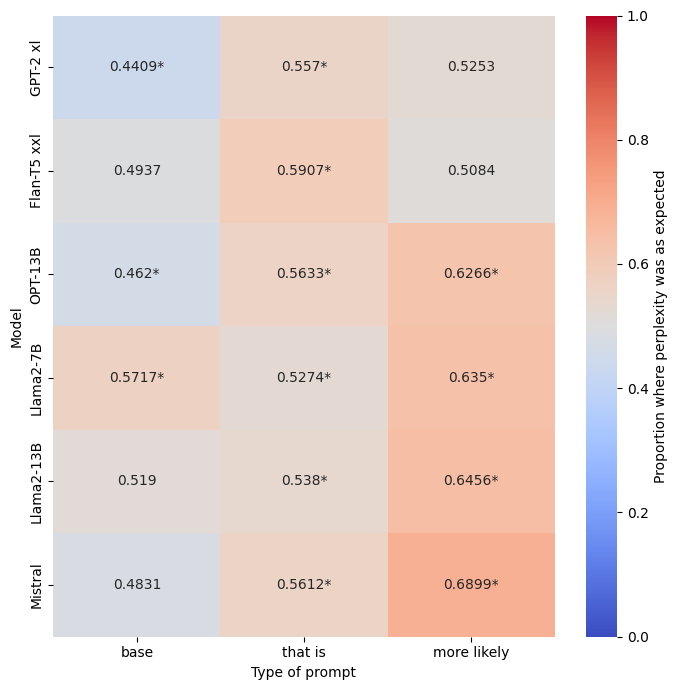

In [24]:
# Plot heatmap
labels = check_significance(exp2_data, matrix)
df_cm = pd.DataFrame(matrix,
                     index = ["GPT-2 xl", "Flan-T5 xxl", "OPT-13B", "Llama2-7B", "Llama2-13B", "Mistral"],
                     columns = ["base", "that is", "more likely"]
              )
green = seaborn.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize = (7,7))
plt.tight_layout()
heatmap = seaborn.heatmap(df_cm, fmt = '', cmap=green, vmin=0, vmax=1, cbar_kws={'label': 'Proportion where perplexity was as expected'}, annot=labels)
heatmap.set(xlabel="Type of prompt", ylabel='Model')
fig = heatmap.get_figure()
fig.tight_layout()
fig.savefig(f"exp2 heatmap domain {domain}.pdf", format="pdf")

# Experiment 2 violin plot

In [25]:
labels = []
domain = 0
temp = pd.DataFrame(data = {"Sentence":[], "Type":[], "Model":[], "Underspecified":[], "diff":[], "log diff":[]})
# For each model, calculate the difference between correct and incorrect continuations
# for each prompt, each reading and both underspecified/specified
for model in ["GPT2-xl", "Flan-T5 xxl", "OPT-13b", "Llama2-7b", "Llama2-13b", "Mistral"]:
  for reading in ["", "counter "]:
    for prompttype in ["base"]:
    #for prompttype in ["base", "thatis", "more-likely"]:
      for typetje in ["Underspecified", "More specified"]:
        sentences = exp2_data['underspecified sentence'] + ". " + exp2_data['continuation of control sentence 1']
        modellist = [model] * len(exp2_data)
        typetjelist = [typetje] * len(exp2_data)
        domainlist = exp2_data["type"]
        und = "sen" if typetje == "Underspecified" else "csen"
        diff = (exp2_data[f"{model} {reading}{prompttype} {und}_correct"] - exp2_data[f"{model} {reading}{prompttype} {und}_incorrect"]).apply(lambda x: abs(x))
        log_diff = diff.apply(lambda x: math.log(x))
        temp = pd.concat([temp, pd.DataFrame(data = {"Sentence":sentences, "Type":domainlist, "Model":modellist, "Underspecified":typetjelist, "diff":diff, "log diff":log_diff})], ignore_index=True)
  pvalue = wilcoxon(temp[(temp["Model"] == model) & (temp["Underspecified"] == "More specified")]['diff'], temp[(temp["Model"] == model) & (temp["Underspecified"] == "Underspecified")]['diff'], alternative='greater').pvalue
  domainpvalue = wilcoxon(temp[(temp["Model"] == model) & (temp["Underspecified"] == "More specified") & (temp["Type"] == domain)]['diff'], temp[(temp["Model"] == model) & (temp["Underspecified"] == "Underspecified") & (temp["Type"] == domain)]['diff'], alternative='greater').pvalue
  pvalue = pvalue if domain == 0 else domainpvalue
  label = "p<0.001" if round(pvalue, 3) == 0 else "p=" + str(round(pvalue, 3))
  labels.append(model + "\n" + label)

<ipython-input-26-4f9bda0eb81b>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set(yticklabels=labels)


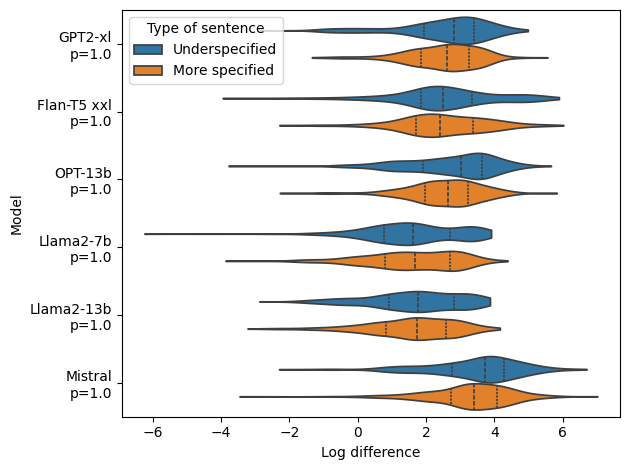

In [26]:
# Plot violin plot
temp = temp if domain == 0 else temp[temp["Type"] == domain]
plot = seaborn.violinplot(data=temp, x="log diff", y="Model", hue="Underspecified", orient="h", cut=0, inner="quart")
plot.set(xlabel="Log difference", ylabel='Model')
plot.set(yticklabels=labels)
#plot.set(yticklabels=["GPT-2 xl", "Flan-T5 xxl", "OPT-13B", "Llama2-7B", "Llama2-13B", "Mistral"])
plot.legend(title='Type of sentence')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(f"exp2 violinplot domain {domain}.pdf", format="pdf")

# Appendix logistic regression

In [ ]:
csen_c = []
csen_i = []
sen_c = []
sen_i = []
for sen, csen, c, i in zip(exp2_data['underspecified sentence'],
                           exp2_data['control sentence 1'],
                           exp2_data['continuation of control sentence 1'],
                           exp2_data['continuation of control sentence 2']):
  sen_c.append(f"{sen}. That is, {c}")
  sen_i.append(f"{sen}. That is, {i}")
  csen_c.append(f"{csen}. That is, {c}")
  csen_i.append(f"{csen}. That is, {i}")
exp2_data['csen_c'] = csen_c
exp2_data['csen_i'] = csen_i
exp2_data['sen_c'] = sen_c
exp2_data['sen_i'] = sen_i

In [ ]:
def process(sen):
  words = sen.split()
  words = list(map(lambda x: "".join([y for y in x if y.isalnum()]), words))
  words = list(map(lambda x: x.lower(), words))
  return words

exp2_data['csen_c length in words'] = exp2_data['csen_c'].apply(lambda x: len(process(x)))
exp2_data['csen_c word length'] = exp2_data['csen_c'].apply(lambda x: sum(len(word) for word in process(x)) / len(process(x)))
exp2_data['csen_i length in words'] = exp2_data['csen_i'].apply(lambda x: len(process(x)))
exp2_data['csen_i word length'] = exp2_data['csen_i'].apply(lambda x: sum(len(word) for word in process(x)) / len(process(x)))
exp2_data['sen_c length in words'] = exp2_data['sen_c'].apply(lambda x: len(process(x)))
exp2_data['sen_c word length'] = exp2_data['sen_c'].apply(lambda x: sum(len(word) for word in process(x)) / len(process(x)))
exp2_data['sen_i length in words'] = exp2_data['sen_i'].apply(lambda x: len(process(x)))
exp2_data['sen_i word length'] = exp2_data['sen_i'].apply(lambda x: sum(len(word) for word in process(x)) / len(process(x)))

In [ ]:
# Load concreteness ratings and calculate conreteness for data
df4 = pd.read_csv('Concreteness_ratings_Brysbaert_et_al_BRM.txt', sep='\t')
concreteness_dict = dict(zip(df4['Word'], df4['Conc.M']))
def find_concreteness(word):
  try:
    return concreteness_dict[word]
  except:
    return df4['Conc.M'].mean()

exp2_data['csen_c average concreteness'] = exp2_data['csen_c'].apply(lambda x: sum(find_concreteness(word) for word in process(x)) / len(process(x)))
exp2_data['csen_i average concreteness'] = exp2_data['csen_i'].apply(lambda x: sum(find_concreteness(word) for word in process(x)) / len(process(x)))
exp2_data['sen_c average concreteness'] = exp2_data['sen_c'].apply(lambda x: sum(find_concreteness(word) for word in process(x)) / len(process(x)))
exp2_data['sen_i average concreteness'] = exp2_data['sen_i'].apply(lambda x: sum(find_concreteness(word) for word in process(x)) / len(process(x)))

In [ ]:
# Load AoA ratings and calculate AoA for data
df5 = pd.read_excel("AoA_ratings_Kuperman_et_al_BRM.xlsx")
AoA_dict = dict(zip(df5['Word'], df5['Rating.Mean']))
def find_AoA(word):
  try:
    return AoA_dict[word]
  except:
    return df5['Rating.Mean'].mean()

exp2_data['csen_c average AoA'] = exp2_data['csen_c'].apply(lambda x: sum(find_AoA(word) for word in process(x)) / len(process(x)))
exp2_data['csen_i average AoA'] = exp2_data['csen_i'].apply(lambda x: sum(find_AoA(word) for word in process(x)) / len(process(x)))
exp2_data['sen_c average AoA'] = exp2_data['sen_c'].apply(lambda x: sum(find_AoA(word) for word in process(x)) / len(process(x)))
exp2_data['sen_i average AoA'] = exp2_data['sen_i'].apply(lambda x: sum(find_AoA(word) for word in process(x)) / len(process(x)))

In [ ]:
df6 = pd.read_csv("unigram_freq.csv")
df6['count'] = df6['count']/max(df6['count'])

word_freq_dict = dict(zip(df6['word'], df6['count']))
def find_freq(word):
  try:
    return word_freq_dict[word]
  except:
    return df6['count'].mean()

exp2_data['csen_c avg. word frequency'] = exp2_data['csen_c'].apply(lambda x: sum(find_freq(word) for word in process(x)) / len(process(x)))
exp2_data['csen_i avg. word frequency'] = exp2_data['csen_i'].apply(lambda x: sum(find_freq(word) for word in process(x)) / len(process(x)))
exp2_data['sen_c avg. word frequency'] = exp2_data['sen_c'].apply(lambda x: sum(find_freq(word) for word in process(x)) / len(process(x)))
exp2_data['sen_i avg. word frequency'] = exp2_data['sen_i'].apply(lambda x: sum(find_freq(word) for word in process(x)) / len(process(x)))

In [ ]:
for model in ["OPT-13b", "Llama2-7b", 'Llama2-13b', "GPT2-xl", "Mistral", "Flan-T5 xxl"]:
  exp2_data[f"{model} csen_c-csen_i"] = exp2_data[f"{model} thatis csen_correct"] < exp2_data[f"{model} thatis csen_incorrect"]
  exp2_data[f"{model} sen_c-sen_i"] = exp2_data[f"{model} thatis sen_correct"] < exp2_data[f"{model} thatis sen_incorrect"]
  for promptorder in ['sen_correct', 'sen_incorrect', 'csen_correct', 'csen_incorrect']:
    exp2_data = exp2_data.drop(columns=[f"{model} thatis {promptorder}"])

In [ ]:
summaries = []
for model in ["GPT2-xl", "Flan-T5 xxl", "OPT-13b", "Mistral", "Llama2-7b", "Llama2-13b"]:
#for model in ["Mistral", "Llama2-7b", "Llama2-13b"]:
    x1 = exp2_data['csen_c length in words']
    x2 = exp2_data['csen_c average AoA']
    x3 = exp2_data['csen_c average concreteness']
    x4 = exp2_data['csen_c avg. word frequency']
    x5 = exp2_data["csen_c word length"]
    X = np.column_stack([x1, x2, x3, x4, x5])
    y = exp2_data[model + " csen_c-csen_i"]
    model = sm.Logit(y, X, formula='y~x1 + x2 + x3 + x4 + x5')
    #model = sm.Logit(y, X, formula='y~x2 + x3 + x4')
    result = model.fit()
    summaries.append(result.summary())

# Calculate average coefficients
average_coefs = []
for summary in summaries:
  coefs = summary.tables[1].data[1:]
  coefs = [[float(text) for text in row[1:]] for row in coefs]
  average_coefs.append(coefs)

average_coefs = np.average(average_coefs, 0).tolist()

In [ ]:
def generate_latex_table(text):
    lines = text.split('\n')
    table_header = r"""
\begin{table}[ht]
\centering
\caption{Average regression coefficients}
\begin{tabular}{lcccccc}
Variable & Coefficient & Standard Error & $z$ & $P>|z|$ & $[0.025$ & $0.0975]$\\
\hline
"""
    table_footer = r"""
\end{tabular}
\end{table}
"""
    table_rows = []
    for line, variable in zip(lines, ["sen. len.", "avg. AoA.", "avg. conc.", "avg. word freq.", "avg. word len."]):
        table_rows.append(variable + " & " + line)

    latex_table = table_header + "\n".join(table_rows) + table_footer
    return latex_table

text = "\\\\\n".join([" & ".join([str(round(value, 4)) for value in coefs_row]) for coefs_row in average_coefs])
print(generate_latex_table(text))